# Crime Analysis

# Introduction:

Drugs are chemically synthesised chemicals that have the ability to modify a person's mental and physical health. When someone takes drugs, especially in large doses, they are likely to participate in dangerous behaviours, such as using a gun to hurt someone else. Drug users are disproportionately represented among those who have access to weapons and may use them in the commission of violent crimes,those with a desperate need for drugs are also more likely to try to sell their weapons in exchange for the money they'll need to buy drugs [8]. Recent studies have shown that just the fact that weapons or guns were used in a crime can help us figure out what happened [7]. Murders and other offences committed with firearms are instances of violent behaviour that society cannot tolerate. Drug use and gun violence have recently emerged as topics of intense interest among both the general public and lawmakers [11].
 


# Aim:

This is to determine, based on the datasets provided and to check the growth of violent crime, whether Birmingham has more gun-related offences per person than any other city in Britain and if there is a correlation between drug use and access to firearms.


# Objectives and Approach:

There are four data sets that can be used to look into gun violence, drug use, and other violent crime-related issues. Since the core dataset, the full crime dataset, is a huge file, it was saved in blob storage, and a Linux virtual machine was built up using Microsoft Azure and Docker containers to execute the Jupiter notebook and an Apache Spark-based query.
Statistical analysis and machine learning algorithms are used to check the claims made in the "Aim" section. For machine learning in time series, the Sarimax model is used, and correlation is used for statistical analysis.

In [58]:
#Importing all necessary packages

%matplotlib inline
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix

import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt
from pyspark import SparkFiles
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation,Summarizer
from pyspark.sql.functions import *
from functools import reduce
from sklearn.metrics import mean_absolute_error
import itertools
warnings.filterwarnings("ignore")

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [2]:
# start/Build the spark session

ss = SparkSession\
.builder\
.appName("Crime Data")\
.getOrCreate()

#Check the Spark Context
sc = ss.sparkContext
sc

<SparkContext master=local[*] appName=Crime Data>

In [3]:
#Reading the file(all_crimes21_hdr.txt.gz) from blob storage and placing it in the dataframe df as a csv file.

url = "https://finalproject12.blob.core.windows.net/crime/all_crimes21_hdr.txt.gz"
ss.sparkContext.addFile(url)
df = ss.read.csv("file://"+SparkFiles.get("all_crimes21_hdr.txt.gz"), header=True, inferSchema= True)

In [4]:
# provides a list of columns in Python format.

column_names = df.columns 
print(column_names)

['Crime ID', 'Month', 'Reported by', 'Falls within', 'Longitude', 'Latitude', 'Location', 'LSOA code', 'LSOA name', 'Crime type', 'Last outcome category', 'Context']


In [5]:
# Changing the existing column names so that they are easy to understand and choose when doing the operations by using lambda function

df1 = list(map(lambda item : item.replace(" ","_"),column_names)) 
df2 = reduce(lambda file, i: file.withColumnRenamed(column_names[i], df1[i]), range(len(column_names)), df)


In [6]:
# Returns the structure of the schema 
df2.schema

StructType(List(StructField(Crime_ID,StringType,true),StructField(Month,StringType,true),StructField(Reported_by,StringType,true),StructField(Falls_within,StringType,true),StructField(Longitude,DoubleType,true),StructField(Latitude,DoubleType,true),StructField(Location,StringType,true),StructField(LSOA_code,StringType,true),StructField(LSOA_name,StringType,true),StructField(Crime_type,StringType,true),StructField(Last_outcome_category,StringType,true),StructField(Context,StringType,true)))

In [7]:
#Returns the count of rows available in dataset
df2.count()

65078250

In [8]:
#The final string of 5 characters will be removed, and the first string will be used in a new column named "city."
#To get the exact city names in UK.

df3=df2.withColumn("City",expr("substring(LSOA_name, 1, length(LSOA_name)-5)"))
df3.columns

['Crime_ID',
 'Month',
 'Reported_by',
 'Falls_within',
 'Longitude',
 'Latitude',
 'Location',
 'LSOA_code',
 'LSOA_name',
 'Crime_type',
 'Last_outcome_category',
 'Context',
 'City']

In [9]:
#Reading the file(LSOA_pop_v2.csv) from blob storage and placing it in the dataframe df3 as a csv file.

url = "https://finalproject12.blob.core.windows.net/data1/LSOA_pop_v2.csv"
ss.sparkContext.addFile(url)
df4 = ss.read.csv("file://"+SparkFiles.get("LSOA_pop_v2.csv"), header=True, inferSchema= True)

#Returns the column names of the dataframe df3
df4.columns

['date',
 'geography',
 'geography code',
 'Rural Urban',
 'Variable: All usual residents; measures: Value',
 'Variable: Males; measures: Value',
 'Variable: Females; measures: Value',
 'Variable: Lives in a household; measures: Value',
 'Variable: Lives in a communal establishment; measures: Value',
 'Variable: Schoolchild or full-time student aged 4 and over at their non term-time address; measures: Value',
 'Variable: Area (Hectares); measures: Value',
 'Variable: Density (number of persons per hectare); measures: Value']

In [10]:
#Renaming the column-names to understand and easy to read and join the dataframes.

df5 = df4.withColumnRenamed("date", "Year")\
         .withColumnRenamed("geography", "LSOA_name")\
         .withColumnRenamed("geography code", "LSOA_code")\
         .withColumnRenamed("Variable: All usual residents; measures: Value", "Population")

#Creating new column as city which will take the first string and removes the last string with the character length of 5.
#To get the exact city names in UK.

df6=df5.withColumn("City",expr("substring(LSOA_name, 1, length(LSOA_name)-5)"))
df6.columns
df6.show(5)

+----+---------------+---------+-----------+----------+--------------------------------+----------------------------------+-----------------------------------------------+------------------------------------------------------------+----------------------------------------------------------------------------------------------------------+------------------------------------------+------------------------------------------------------------------+----------+
|Year|      LSOA_name|LSOA_code|Rural Urban|Population|Variable: Males; measures: Value|Variable: Females; measures: Value|Variable: Lives in a household; measures: Value|Variable: Lives in a communal establishment; measures: Value|Variable: Schoolchild or full-time student aged 4 and over at their non term-time address; measures: Value|Variable: Area (Hectares); measures: Value|Variable: Density (number of persons per hectare); measures: Value|      City|
+----+---------------+---------+-----------+----------+-----------------------

In [11]:
#Task1-Filtering the Violent crime from whole data to analyse whether it is increasing or decreasing or stable
#Flitering the data using crime_type as "Violent crime" or "Violence and Sexual Offences".
#The data available for violent crime is only until 2013 from 2013 to 2021 it changed to violence and sexual offences.

dfg1=(df3.select(df3.Month, df3.Crime_type).where((df3.Crime_type == 'Violent crime') | (df3.Crime_type == 'Violence and sexual offences'))\
    .groupby("Month", "Crime_type")
    .agg(count("Crime_type").alias("Count_Crimetype"))
    .orderBy("Month", ascending = True))

#View the Data
dfg1.show(truncate=False)

#Return only three columns from last
dfg1.tail(3)


+-------+-------------+---------------+
|Month  |Crime_type   |Count_Crimetype|
+-------+-------------+---------------+
|2010-12|Violent crime|57580          |
|2011-01|Violent crime|59823          |
|2011-02|Violent crime|56691          |
|2011-03|Violent crime|62326          |
|2011-04|Violent crime|64299          |
|2011-05|Violent crime|63633          |
|2011-06|Violent crime|62475          |
|2011-07|Violent crime|66572          |
|2011-08|Violent crime|63284          |
|2011-09|Violent crime|57150          |
|2011-10|Violent crime|60076          |
|2011-11|Violent crime|56895          |
|2011-12|Violent crime|56163          |
|2012-01|Violent crime|56324          |
|2012-02|Violent crime|50598          |
|2012-03|Violent crime|58606          |
|2012-04|Violent crime|53415          |
|2012-05|Violent crime|59541          |
|2012-06|Violent crime|56816          |
|2012-07|Violent crime|60199          |
+-------+-------------+---------------+
only showing top 20 rows



[Row(Month='2021-03', Crime_type='Violence and sexual offences', Count_Crimetype=166668),
 Row(Month='2021-04', Crime_type='Violence and sexual offences', Count_Crimetype=153789),
 Row(Month='2021-05', Crime_type='Violence and sexual offences', Count_Crimetype=171614)]

In [12]:
#Converting dataframe to pandas

pf = dfg1.toPandas()

#Converting the Pandas Dataframe to be TimeIndexed to carry out the next step using in Timeseries

pf.Month = pf.Month.astype('datetime64[ns]')
pf1 = pf.set_index(pd.to_datetime(pf.Month))

pf2 = pf1.loc['2010-12':]
pf2.index

DatetimeIndex(['2010-12-01', '2011-01-01', '2011-02-01', '2011-03-01',
               '2011-04-01', '2011-05-01', '2011-06-01', '2011-07-01',
               '2011-08-01', '2011-09-01',
               ...
               '2020-08-01', '2020-09-01', '2020-10-01', '2020-11-01',
               '2020-12-01', '2021-01-01', '2021-02-01', '2021-03-01',
               '2021-04-01', '2021-05-01'],
              dtype='datetime64[ns]', name='Month', length=126, freq=None)

In [13]:
# Task 2: We want to see if there are more guns per person in Birmingham than in other parts of the UK.
# Therefore, using the all crimes21 hdr.txt.gz data, I filtered out the crime type for guns, choosing Possession of Weapons as the crime type and offender sent to prison as last_outcome_category
 
dfg2=(df3.select(df3.Crime_type, df3.City).where((df3.Crime_type == 'Possession of weapons') & (df3.Last_outcome_category == 'Offender sent to prison'))\
    .groupby("Crime_type", "City")
    .agg(count("Crime_type").alias("Count_Crimetype")).dropna()
    .orderBy("City", ascending = True))

dfg2.show()


+--------------------+--------------------+---------------+
|          Crime_type|                City|Count_Crimetype|
+--------------------+--------------------+---------------+
|Possession of wea...|                Adur|              2|
|Possession of wea...|           Allerdale|             21|
|Possession of wea...|        Amber Valley|             27|
|Possession of wea...|                Arun|             14|
|Possession of wea...|            Ashfield|             21|
|Possession of wea...|             Ashford|             15|
|Possession of wea...|      Aylesbury Vale|             27|
|Possession of wea...|             Babergh|              3|
|Possession of wea...|Barking and Dagenham|             49|
|Possession of wea...|              Barnet|             43|
|Possession of wea...|            Barnsley|             64|
|Possession of wea...|   Barrow-in-Furness|             19|
|Possession of wea...|            Basildon|             36|
|Possession of wea...|Basingstoke and D.

In [14]:
#Grouping the city with population.

dfg3=(df6.select(df6.Population, df6.City))\
    .groupby("City")\
    .agg(sum("Population").alias("Total_Population"))\
    .orderBy("City", ascending = True)

dfg3.show()

+--------------------+----------------+
|                City|Total_Population|
+--------------------+----------------+
|                Adur|           61182|
|           Allerdale|           96422|
|        Amber Valley|          122309|
|                Arun|          149518|
|            Ashfield|          119497|
|             Ashford|          117956|
|      Aylesbury Vale|          174137|
|             Babergh|           87740|
|Barking and Dagenham|          185911|
|              Barnet|          356386|
|            Barnsley|          231221|
|   Barrow-in-Furness|           69087|
|            Basildon|          174497|
|Basingstoke and D...|          167799|
|           Bassetlaw|          112863|
|Bath and North Ea...|          176016|
|             Bedford|          157479|
|              Bexley|          231997|
|          Birmingham|         1073045|
|               Blaby|           93915|
+--------------------+----------------+
only showing top 20 rows



In [15]:
#Joining two dataframes, all_crimes21_hdr.txt.gz and LSOA_pop_v2, to get the population per head in all the cities using some filtering techniques.
data3 = dfg2.join(dfg3, (dfg2.City == dfg3.City))\
            .select(dfg3.City, dfg2.Crime_type,dfg3.Total_Population,dfg2.Count_Crimetype).withColumn("population-per-head" , ((dfg2.Count_Crimetype / dfg3.Total_Population)*100))\
            .orderBy("population-per-head", ascending = False).drop("Total_Population","Count_Crimetype")

data3.show()

+------------------+--------------------+--------------------+
|              City|          Crime_type| population-per-head|
+------------------+--------------------+--------------------+
|    City of London|Possession of wea...|  0.2305084745762712|
|       Westminster|Possession of wea...| 0.05879779029699721|
|             Derby|Possession of wea...|0.052260886344632405|
|           Norwich|Possession of wea...|0.049806809949287614|
|        Nottingham|Possession of wea...| 0.04841664485736718|
|        Darlington|Possession of wea...| 0.04736463188208101|
|    Stoke-on-Trent|Possession of wea...| 0.04578166163336118|
|Kingston upon Hull|Possession of wea...| 0.04563075747057401|
|           Lambeth|Possession of wea...|  0.0455316312861696|
|       Scarborough|Possession of wea...| 0.04320130890774223|
|           Watford|Possession of wea...|0.043188890488477426|
|         Islington|Possession of wea...|0.043177683444511825|
|            Torbay|Possession of wea...|  0.0427614749

In [16]:
#Task 3: Check the relationship between guns and drugs to see if it is related to them or not.

#Possession of weapons was selected as a Gun/Firearm incident for Firearms_count in all_crimes21_hdr.txt.gz data. 

data4=(df3.select(df3.Crime_type, df3.City).where((df3.Crime_type == 'Possession of weapons'))
     .groupby("City", "Crime_type")
     .agg(count("Crime_type").alias("Firearms_Count")).dropna()
    .orderBy("City", ascending = True))

data4.show()

#Choosen the drugs for drugs count from the all_crimes21_hdr.txt.gz data.

data5=(df3.select(df3.Crime_type, df3.City).where((df3.Crime_type == 'Drugs'))
     .groupby("City", "Crime_type")
     .agg(count("Crime_type").alias("Drugs_Count")).dropna()
    .orderBy("City", ascending = True))

data5.show()


+--------------------+--------------------+--------------+
|                City|          Crime_type|Firearms_Count|
+--------------------+--------------------+--------------+
|                Adur|Possession of wea...|           317|
|           Allerdale|Possession of wea...|           317|
|        Amber Valley|Possession of wea...|           411|
|                Arun|Possession of wea...|           863|
|            Ashfield|Possession of wea...|           654|
|             Ashford|Possession of wea...|           409|
|      Aylesbury Vale|Possession of wea...|           585|
|             Babergh|Possession of wea...|           183|
|Barking and Dagenham|Possession of wea...|           932|
|              Barnet|Possession of wea...|           985|
|            Barnsley|Possession of wea...|          1271|
|   Barrow-in-Furness|Possession of wea...|           367|
|            Basildon|Possession of wea...|          1031|
|Basingstoke and D...|Possession of wea...|           95

In [17]:
# Joining together two data frames to get all the firearms count and drugs count for each city.

data6 = data4.join(data5, (data4.City == data5.City))\
            .select(data4.City, data4.Firearms_Count,data5.Drugs_Count)

data6.show()

+--------------------+--------------+-----------+
|                City|Firearms_Count|Drugs_Count|
+--------------------+--------------+-----------+
|           Worcester|           637|       3384|
|           Charnwood|           582|       2605|
|      North Kesteven|           201|       1037|
|                Arun|           863|       3444|
|       Epping Forest|           472|       2700|
|             Waveney|           517|       2549|
|              Stroud|           199|       1686|
|              Maldon|           140|        769|
|          New Forest|           569|       2524|
|           Sedgemoor|           307|       2202|
|           Guildford|           509|       4180|
|            Worthing|           777|       3194|
|             Fareham|           349|       1604|
|              Bolton|          1290|       4236|
|Central Bedfordshire|           571|       2991|
|      North Tyneside|          1053|       3960|
|        Surrey Heath|           236|       1808|


In [19]:
#Selecting only Firearms_count and Drugs_Count to plot further in correlation
data4_new = data6.select('Firearms_Count', 'Drugs_Count')
data4_new.show()

+--------------+-----------+
|Firearms_Count|Drugs_Count|
+--------------+-----------+
|           637|       3384|
|           582|       2605|
|           201|       1037|
|           863|       3444|
|           472|       2700|
|           517|       2549|
|           199|       1686|
|           140|        769|
|           569|       2524|
|           307|       2202|
|           509|       4180|
|           777|       3194|
|           349|       1604|
|          1290|       4236|
|           571|       2991|
|          1053|       3960|
|           236|       1808|
|           558|       2005|
|          1055|       4396|
|           385|       2744|
+--------------+-----------+
only showing top 20 rows



# Visulaization using Machine learning Models:

I've opted to make things as general as possible, therefore I'm going to do the analysis and visualisation of the data on violent crime using a Times Series that is displayed using the Sarimax Model. Which of the following is the first claim that may be made to determine whether or not there has been an increase in the rate of violent crime. To be more specific, the processes that are described below are applied.


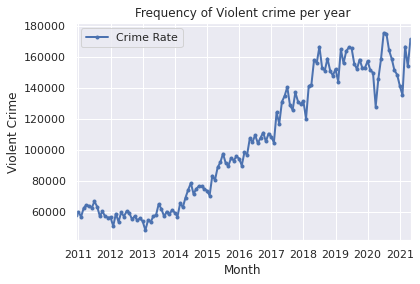

In [20]:
#Task 1 :Plotting graph for Month vs Count_Crimetype(only for violent crime)

plt.figsize = (20, 9)
pf2.plot(y ='Count_Crimetype', x ='Month', marker='.', linestyle = '-', linewidth = 2,\
        label = 'Crime Rate',
        title = 'Frequency of Violent crime per year')
plt.ylabel('Violent Crime')
plt.show()

The plot is shown using a line graph comparing violent crime by month.

From 2010 to 2013, violent crime is categorised as "violent crime," and from 2013 to 2021 as "violence and sexual offences."
From 2013 to 2021, there is a rise in violent crime, however there was a minor decline from 2010 to 2013.

However, based on the line plot, we cannot determine if the value is always growing, steady, or declining.
To gain the best analysis, I built the timeseries using the Sarimax model.

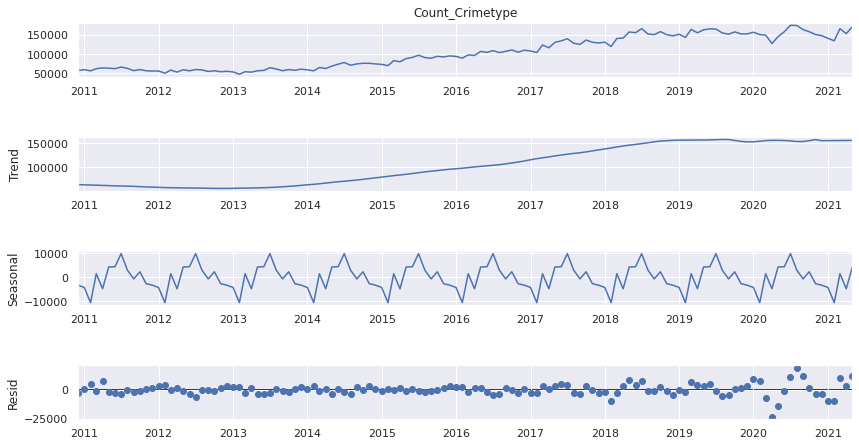

In [21]:
#Decomposition of data using seasonal decompose and the model is using here additive.

decomposition = sm.tsa.seasonal_decompose(pf2['Count_Crimetype'], model='additive',extrapolate_trend='freq')
fig = decomposition.plot()
fig.set_size_inches(14,7)
plt.show()


In this case, we use time series decomposition to investigate the model's complexity and enhance our ability to anticipate outcomes. Models that are either additive or multiplicative might be seen as potential decomposition tools. Nonetheless, I utilised an additive model.From 2014 through 2021, we can see an increase in violent crime, with a little pause in 2020.


In [22]:
### plotting for Rolling Statistic for testing Stationarity

def test_stationarity(timeseries, title):
    plt.clf()
    #Determing rolling statistics
    rmean = pd.Series(timeseries).rolling(window=4).mean() 
    rstd = pd.Series(timeseries).rolling(window=4).std()
    
    fig, ax = plt.subplots(figsize=(18, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rmean, label='rolling mean');
    ax.plot(rstd, label='rolling std (x10)');
    ax.legend()
    plt.show()


Rolling statistics are used in the analysis of stationarity by calculating the mean and standard deviation of the data with a window size of 4.


<Figure size 432x288 with 0 Axes>

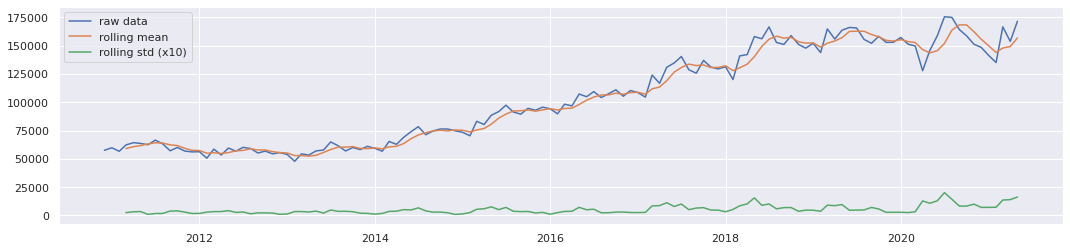

In [23]:
#Displaying the stationarity

pd.options.display.float_format = '{:.8f}'.format
test_stationarity(pf2['Count_Crimetype'],'raw data')

The ADF(Augmented Dickey Fuller) test is used to validate the null and alternative hypothesis tests for statistical significance.

By calculating the p-value, we will know if the term is stationary or not, allowing us to go further with the Sarimax model.


In [24]:
# Augmented Dickey-Fuller(ADF) test

from statsmodels.tsa.stattools import adfuller

def test_ADF(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.2f}'.format(dftest[0]))
    print('P-value = {:.2f}'.format(dftest[1]))
    print('Critical values :')
    for i, j in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(i, j, 'not' if j<dftest[0] else '', 100-int(i[:-1])))

In [25]:
test_ADF(pf2['Count_Crimetype'],'raw data')

 > Is the raw data stationary ?
Test statistic = -0.30
P-value = 0.92
Critical values :
	1%: -3.489589552580676 - The data is not stationary with 99% confidence
	5%: -2.887477210140433 - The data is not stationary with 95% confidence
	10%: -2.580604145195395 - The data is not stationary with 90% confidence


It is clear from looking at the raw data that the data is not stationary. Furthermore, the p-value is higher than 0.05, which means that the test did not pass and the null hypothesis test was rejected [4].

So,Next step moved until getting the data to be stationary.


<Figure size 432x288 with 0 Axes>

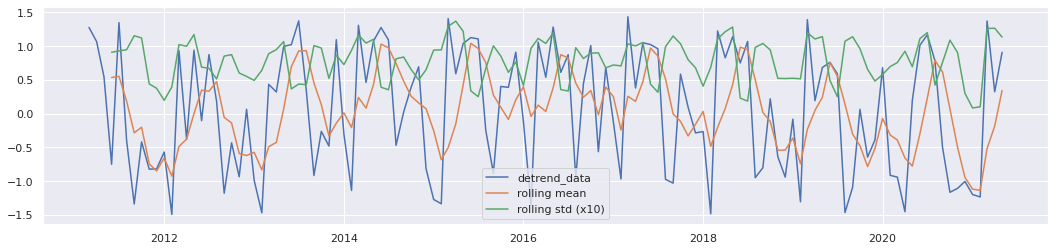

 > Is the detrend_data stationary ?
Test statistic = -1.74
P-value = 0.41
Critical values :
	1%: -3.49181775886872 - The data is not stationary with 99% confidence
	5%: -2.8884437992971588 - The data is not stationary with 95% confidence
	10%: -2.5811201893779985 - The data is not stationary with 90% confidence


In [26]:
# Detrending
x = pf2['Count_Crimetype']
x_detrend =  (x - x.rolling(window=4).mean())/x.rolling(window=4).std()

test_stationarity(x_detrend,'detrend_data')
test_ADF(x_detrend,'detrend_data')


The data is not stationary even after using detrending.The p-value is higher than 0.05, which means that the test did not pass and the null hypothesis test was rejected.


<Figure size 432x288 with 0 Axes>

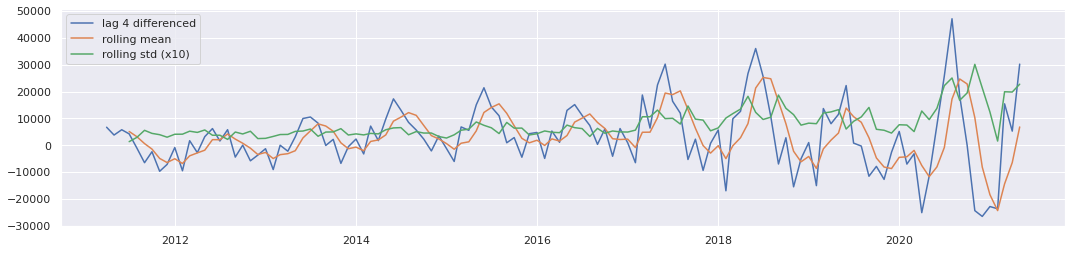

 > Is the lag 4 differenced stationary ?
Test statistic = -1.55
P-value = 0.51
Critical values :
	1%: -3.4924012594942333 - The data is not stationary with 99% confidence
	5%: -2.8886968193364835 - The data is not stationary with 95% confidence
	10%: -2.5812552709190673 - The data is not stationary with 90% confidence


In [27]:
# Differencing
x_lag4 =  x - x.shift(4)

test_stationarity(x_lag4,'lag 4 differenced')
test_ADF(x_lag4,'lag 4 differenced')


The data is not stationary even after using differncing.The p-value is higher than 0.05, which means that the test did not pass and the null hypothesis test was rejected.Until we will get the stationarity we can't use the data to the Sarimax model.


<Figure size 432x288 with 0 Axes>

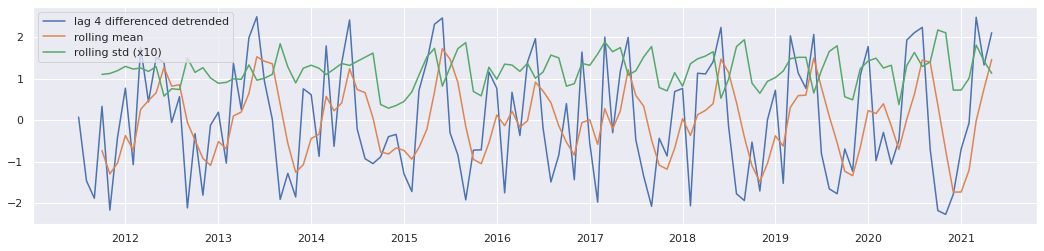

 > Is the lag 4 differenced detrended stationary ?
Test statistic = -6.53
P-value = 0.00
Critical values :
	1%: -3.4924012594942333 - The data is  stationary with 99% confidence
	5%: -2.8886968193364835 - The data is  stationary with 95% confidence
	10%: -2.5812552709190673 - The data is  stationary with 90% confidence


In [28]:
# Detrending + Differencing

x_lag4_de =  x_detrend - x_detrend.shift(4)

test_stationarity(x_lag4_de,'lag 4 differenced detrended')

test_ADF(x_lag4_de,'lag 4 differenced detrended')



The data were able to achieve a stable state after being subjected to detrending and differencing. The p-value is lower than 0.05, which indicates that the test was successful and that the results of the test against the null hypothesis may be 
trusted.

Currently running this dataset through the Sarimax model in order to do data analysis.


In [29]:
#Converting data to csv file

x_lag4_de.to_csv("x_lag4_de.csv")

In [30]:
# Reading the csv file into pandas
file = "x_lag4_de.csv"
pf3 = pd.read_csv(file, parse_dates=['Month'])

In [31]:
#Converting the Pandas Dataframe to be TimeIndexed

pf3.Month = pf3.Month.astype('datetime64[ns]')
x = pf3.set_index(pd.to_datetime(pf3.Month)).dropna().Count_Crimetype
x.head()

Month
2011-07-01    0.07081351
2011-08-01   -1.46467691
2011-09-01   -1.88424689
2011-10-01    0.33194756
2011-11-01   -2.16997164
Name: Count_Crimetype, dtype: float64


The dataset will be divided into train and test data after the conversion is complete.


In [32]:
#Spliting the data into a training and test dataset

x_train = x[:'2016-12-01']  # dataset to train
x_test = x['2017-01-01': ]  # dataset to test  

x_val = x_test

In [33]:
#Setting up the sarimax model with p,d,q values.

p = d = q = range(0, 2)
seasonal_period = 12
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))


Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)



The task that lies ahead of us is to determine which model is more appropriate for making forecasts based on the timeseries information. selected the Sarimax model to predict by applying it to the historical data. 

The Sarimax model transforms the data from the training and the testing into an appropriate set of values. As a result of the fact that seasonal factors come into play, we make use of an algorithm known as SARIMAX, which stands for Seasonal Auto-Regressive Integrated Moving Average with eXogenous factors [5].


In [34]:
#Training the SARIMAX model

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod =\
            sm.tsa.statespace.SARIMAX(x_train,
                                      order=param,
                                      seasonal_order=param_seasonal,
                                      enforce_invertibility=False)
            res = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, res.aic))
        except Exception as ex:
            print(ex)
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:223.28182830039293
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:200.24614926220056
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:143.792206989725
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:131.64787813223847
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:178.47435292486986
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:171.2993961705991
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:132.7088943824816
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:133.42763093053182
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:222.10714045956698
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:199.71760351726695
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:143.40861525062272
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:132.1316707123715
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:178.34862008597432
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:171.27823203489825
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:134.17073833129152
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:134.1273742732538
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:247.1362163525427
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:228.18725703815582

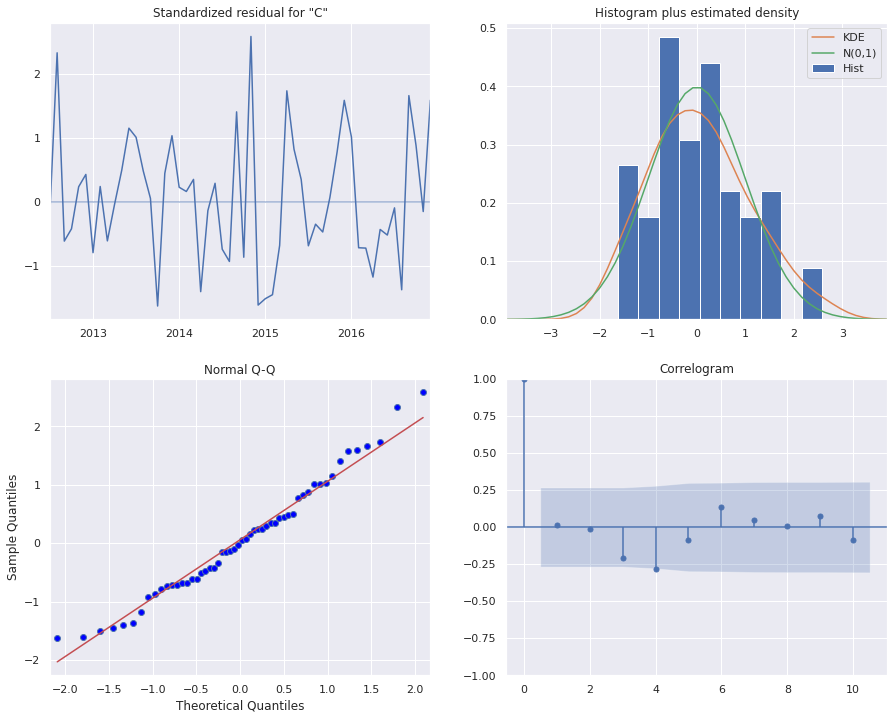

In [35]:
#ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:131.0001825890002
order = (1, 0, 1) #Using Values from the last step
seasonal_order = (0, 1, 1, 12)
model = sm.tsa.statespace.SARIMAX(x_train,
                            order=order,
                            seasonal_order=seasonal_order,
                            enforce_invertibility=False)
resu = model.fit()

resu.plot_diagnostics(figsize=(15, 12))
plt.show()


The model described above made use of the AIC(Akaike information criterion) least value. To get more accurate projected values
The plots described above, which include a standardised residual plot, a histogram plot, a Normal Q-Q plot, and a correlogram plot. These plots will be used, along with the standard deviation, the mean, the linear regression, and the correlation, to produce more accurate results in terms of the data and the timeseries.


In [36]:
#setting the forecast steps

preuc = resu.get_forecast(steps=8)
preci = preuc.conf_int()


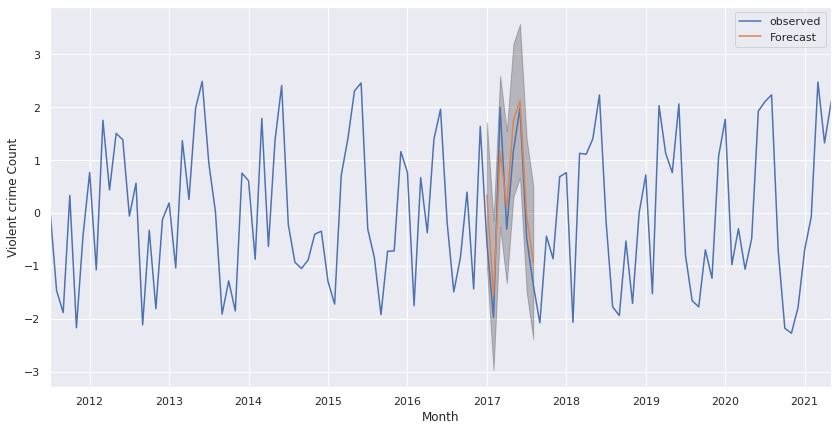

In [53]:
#Plotting the forecast and observed values.

ax = x.plot(label='observed', figsize=(14, 7))
preuc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(preci.index,
                preci.iloc[:, 0],
                preci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Month')
ax.set_ylabel('Violent crime Count')

plt.legend()
plt.show()


From the prediction and actual values shown above in the graph plotting the relationship between violent crime and time series data, one is able to observe that the prognosis for 2017 is more severe than the actual numbers.

From this we can see increase in the violent crime from 2013 till 2021.


In [54]:
# Predicted mean

pm = preuc.predicted_mean.reset_index()
pm.columns = ['Month','Predicted_Mean']
pci = preci.reset_index()
pci.columns = ['Month','Lower Bound','Upper Bound']

In [56]:
# Produce the forcasted tables 

pm = preuc.predicted_mean.reset_index()
pm.columns = ['Month','Predicted_Mean']
pci = preci.reset_index()
pci.columns = ['Month','Lower Bound','Upper Bound']
fin = pm.join(pci.set_index('Month'), on='Month')
final_table = fin.merge(x_test, left_on='Month', right_on='Month', how='inner')
final_table.head(12)

,Month,Predicted_Mean,Lower Bound,Upper Bound,Count_Crimetype
0,2017-01-01,0.33846704,-1.03757347,1.71450755,-0.56423643
1,2017-02-01,-1.55784712,-2.97058682,-0.14510742,-1.97707963
2,2017-03-01,1.16745500,-0.26480765,2.59971766,1.99906442
3,2017-04-01,0.10996422,-1.33275639,1.55268483,-0.30551243
4,2017-05-01,1.75310680,0.30480526,3.20140834,1.17322983
5,2017-06-01,2.12443129,0.67323341,3.57562916,1.99228521
6,2017-07-01,-0.03905060,-1.48822643,1.41012523,-0.47396433
7,2017-08-01,-0.93474469,-2.38481927,0.51532990,-1.35300243


In [41]:
#Viewing the test data rows

x_test.head(12)

Month
2017-01-01   -0.56423643
2017-02-01   -1.97707963
2017-03-01    1.99906442
2017-04-01   -0.30551243
2017-05-01    1.17322983
2017-06-01    1.99228521
2017-07-01   -0.47396433
2017-08-01   -1.35300243
2017-09-01   -2.07950285
2017-10-01   -0.43863935
2017-11-01   -0.86656623
2017-12-01    0.68777513
Name: Count_Crimetype, dtype: float64


##### Task 2 :Checking the birmingham has highest population per head for firearms compared to other cities in UK.


In [ ]:
# Task 2 :Plotting cities vs population-per-head to see the birmingham count
#converting dataframe to pandas

df_pandas = pd.DataFrame(data3.head(10), columns=data3.columns)
df_pandas


As a part of Task 2, we need to determine whether or not Birmingham has a greater population per head of guns than other cities. 

In order to do this, filtered the data from all_crimes21_hdr.txt.gz depending on the "possession of weapons" and "offender sent to prison".

The sum as well as the total of the data from the population that was included in the LSOA_pop_v2 dataset provided the percentage that was needed to produce the result based on population-per-head. In order to establish which of the values is the highest, a bar chart is used.

According to the graph that follows, Birmingham is not among the cities with the largest number of weapons when compared to other cities.

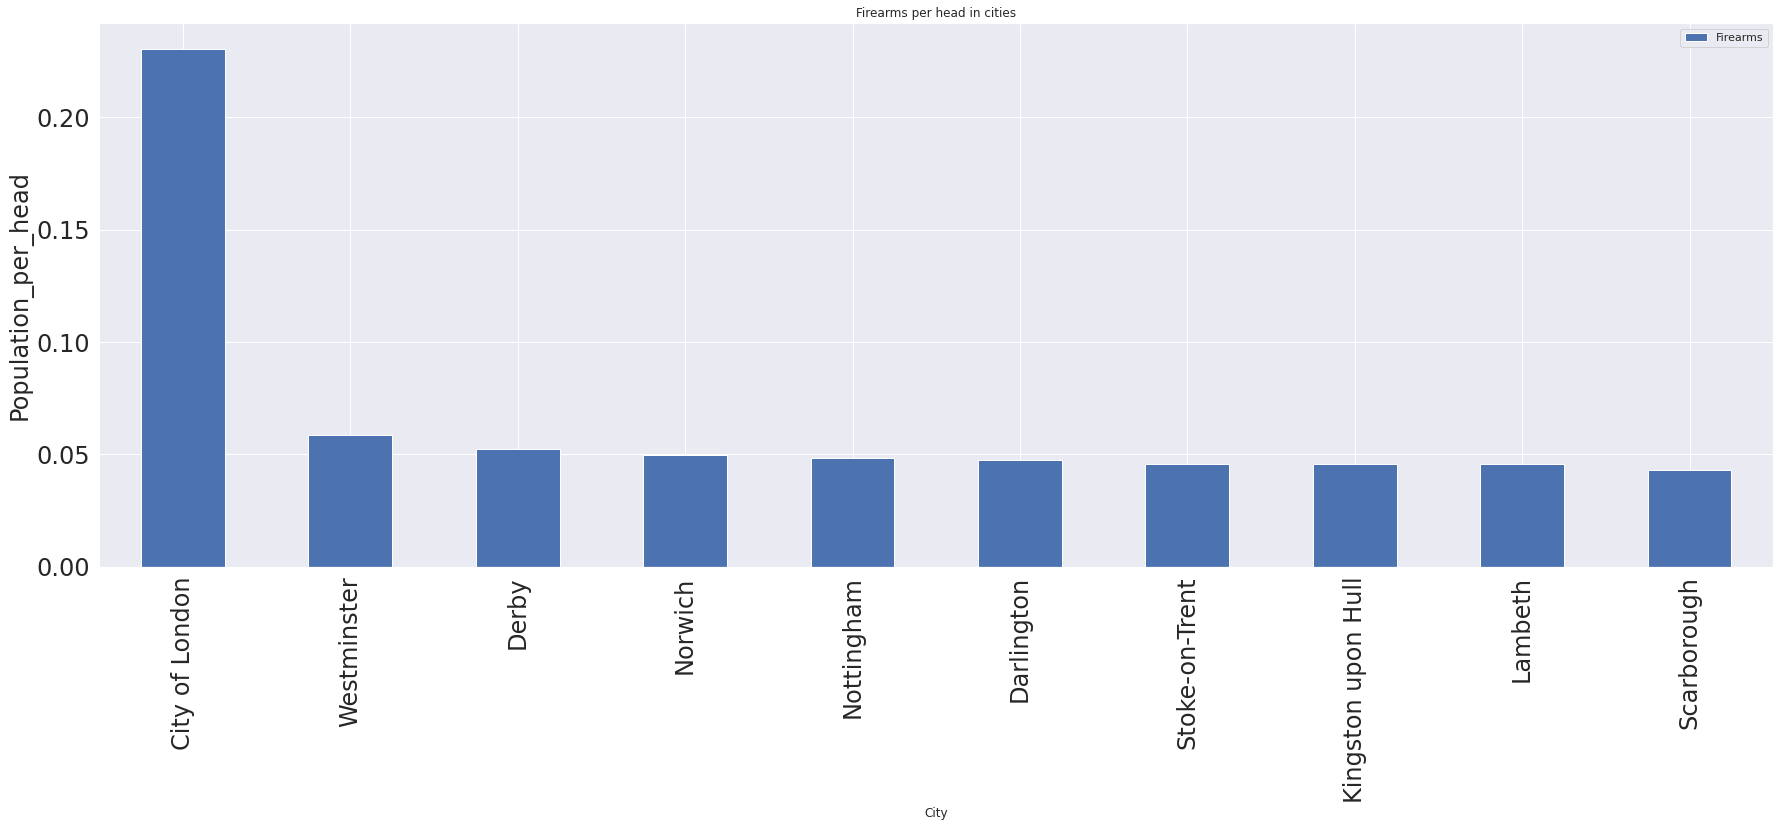

In [43]:
#Plotting the graph city vs population_per_head

plt.figsize = (30, 10)
plt.rcParams.update({'font.size': 24})
df_pandas.plot.bar(y ='population-per-head', x ='City', figsize=(30,10),fontsize=24,\
        label = 'Firearms',
        title = 'Firearms per head in cities',)
plt.ylabel('Population_per_head',fontdict={'fontsize':24})
plt.show() 

# Timeseries Model:

Utilizing a machine learning model in a timeseries makes it feasible to make accurate forecasts about future values. 

In this section, we will compute both the actual values and the values that the model done above for violent crime analysis predicts will be the case. As a result, error detection is performed by taking into account both actual and anticipated values in order to determine the degree to which the model is evaluated.

This may be validated by use RMSE, MAE, and MSE, amongst other similar metrics. In this case, however, I checked the quality of the model using RMSE (Root Mean Square Error) and MAE (Mean Absolute Error) to determine if the model accurately predicts the dataset by evaluating it in its whole or by doing so in an efficient manner.


In [57]:
#Task1 :Checking the rmse value

def rmse(predict, target):
    return np.sqrt(((predict - target) ** 2).mean())

rmse(final_table['Predicted_Mean'], final_table['Count_Crimetype'])

0.56707956795957

In [59]:
#Checking the MAE value

mean_absolute_error(final_table['Count_Crimetype'], final_table['Predicted_Mean'])

0.5167770692083649


The aforementioned RMSE and MAE values are within the range of 0.5, and based on this information, we are able to verify that the model that was employed above is accurately predicting the results. because it is generally agreed that values in the range 0.2 to 0.5 provide for an acceptable model for timeseries [12].




# Task 3: Checking the relationship between Drugs and Firearms.

Used the correlation approach, which is part of statistical analysis, to determine if the two things are related. Consider the dataset named all crimes21 hdr.txt.gz and separate it into two different dataframes: one for the number of guns reported in each city, and the other for the number of drugs reported in each city. After that, I linked the two dataframes together and treated them as a single entity, with the exception of adding count columns for weapons and drugs.

After that, it is changed over to Pandas so that the scatter matrix may be drawn, as is shown below below.

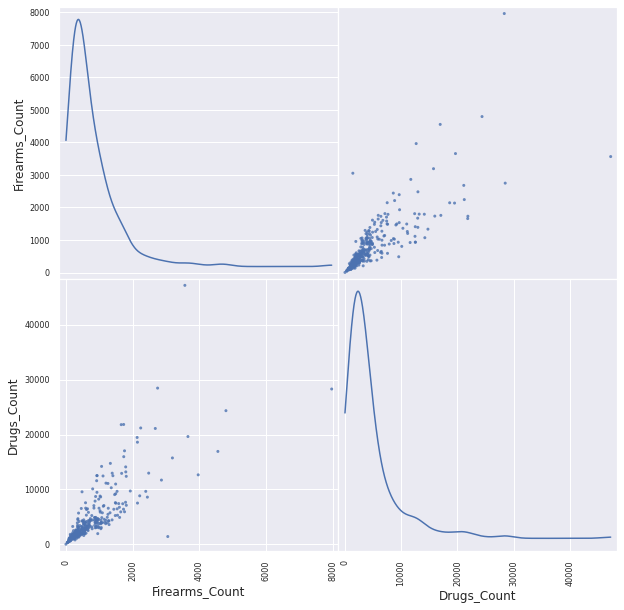

In [44]:
# convert to pandas for plotting
d1 = data4_new.toPandas()
scatter_matrix(d1, alpha=0.8, figsize=(10, 10), diagonal='kde')
#Show the plot
plt.show()


In this particular instance, we used the vector assembler approach in a correlation model using the dataset that was chosen in accordance with the prerequisites.


In [45]:
# Vectorize dataframe
vec_col = "corr_features"
assem = VectorAssembler(inputCols=data4_new.columns, outputCol=vec_col)
df_vector = assem.transform(data4_new).select(vec_col)
df_vector.show(5)

+--------------+
| corr_features|
+--------------+
|[637.0,3384.0]|
|[582.0,2605.0]|
|[201.0,1037.0]|
|[863.0,3444.0]|
|[472.0,2700.0]|
+--------------+
only showing top 5 rows




When trying to ascertain the findings, one may utilise any one of the several correlation matrices that are available.
In this particular instance, though, I made use of the Spearman correlation matrix.


In [46]:
# get Spearman correlation matrix
sma = Correlation.corr(df_vector, vec_col, method='spearman')
spe_cmatrix = sma.collect()[0][sma.columns[0]].toArray()



The following is intended to demonstrate the correlation values between the number of weapons and the number of drugs.


In [47]:
# printing
print('\t'.join([col[0:5] for col in data4_new.columns]))
print("\n".join("\t".join(["{0:.2f}".format(num) for num in list(subList)]) for subList in list(spe_cmatrix)))

Firea	Drugs
1.00	0.90
0.90	1.00


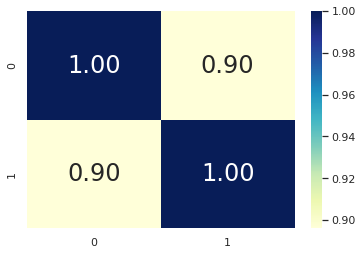

In [48]:
#Heatmap has shown for correlation matrix
ay = sns.heatmap(spe_cmatrix, annot=True, fmt=".2f", cmap="YlGnBu")
plt.show()


We may deduce from the information presented above that the values of the correlation matrix are 0.9, and that it has a positive sign, by which we mean that the presence of drugs and weapons are related to one another.




In order to support or offer proof for the three assertions made about the crime statistics in the UK, those claims are expressed using the data.
In the machine learning approaches, I have decided to make use of timeseries by using the Sarimax model, and for statistical analysis, I will be employing one additional correlation matrix.


# Timeseries for forecasting:

When compared to the results of more complicated approaches or models, the values that have been predicted or projected using timeseries have a higher degree of accuracy.The primary focus of the analysis is placed on the timeseries content in terms of seasonality, heteroscedasticity, and trends [6].And in terms of timeseries, there are a lot of different approaches that may be used when developing a model to predict timeseries data. For the first claim given, it is timeseries data to check whether the violence is increasing or not. To support the claim that this method is appropriate, The Sarimax model, which is rather popular, has taken into account seasonality and order in order to get more accurate findings [5].



# Statistical Analysis using Correlation Matrix:


It is possible to identify the relation between two independent variables by using the correlation matrix [10]. As we can see from the third assertion, the link between drugs and weapons is not reliant on the values of those involved. As a result, decided to use the correlation model to analyse the connection, and inside the correlation, there is a strategy for selecting spearman and pearson. The spearman scatterplot depicts the graph in a monotonic rather than linear fashion, which is why I choose to use it.


# Limitations:

Time series and correlation matrices have a limitation.

The time series may be readily overfit due to the way the false readings are recorded, and it can only be predicted with smaller data sets and is not useful for long-term data forecasting [4] . There are several techniques that, if not correctly adjusted as a consequence of shifts in the time series analysis, will have an effect on the series. If these adjustments are not made, the effects of these methods will be seen in the series. When it comes to the correlation matrix, in general, it functions most effectively for the linear kind of data, and it will not check beyond the values of the two variables to produce a better forecast. This is because the correlation matrix does not consider any other factors.

# Evaluation :

In order to verify the procedures that were utilised to provide support for the three assertions, we employed a machine learning model that was based on timeseries and made use of the Sarimax model. In addition, performed statistical analysis using a correlation matrix.
The results shown above show that the timeseries model generates RMSE and MAE values that are close to 0.5. This indicates that the model is effective in forecasting the timeseries of the dataset that was provided and generated the best possible outcome.
When it comes to statistical analysis, the correlation matrix reveals a value of 0.9, which is very close to being a positive number and indicates that the Spearman technique provides a good match in the correlation matrix [12].


# Conclusion:

For the purpose of verifying the assertions, machine learning models and statistical analysis are used.


•	The timeseries model is used for the first claim by using the Sarimax model, which demonstrates that violent crime is somewhat reducing from 2010 to 2013, but progressively growing from 2013 to 2021. This information is used for the timeseries model, which is utilised for the first claim.Overall, the number of violent crimes committed in the UK is on the rise.

•	Spark SQL and bar plot visualisation allow us to confirm that the second claim about Birmingham is false. Birmingham does not have the largest population per head for weapons in the United Kingdom.

•	For the third assertion, I conducted statistical analysis using a correlation matrix, and from that I was able to deduce that the use of illegal substances(drugs) and firearms/guns are associated with one another.



# REFERENCES:

[1] A. Burinskas, “A review of drugs supply disruption risks and effects that lead to shortage,” Athens Journal of Health and Medical Sciences, vol. 7, no. 1, pp. 1–18, 2020. 

[2] A. L. Carlock and A. J. Lizotte, “Gangs, guns, and violence,” The Handbook of Gangs, pp. 178–192, 2015. 

[3] C. Ferguson, “Violent crime research: An introduction,” Violent Crime: Clinical and Social Implications, pp. 3–18, 2010. 

[4] D. Pachpatte, “7 analysis and forecasting of COVID-19 infections in India using Arima model,” Computational Intelligence for Managing Pandemics, pp. 121–130, 2021. 

[5] F. R. Alharbi and D. Csala, “A seasonal autoregressive integrated moving average with exogenous factors (SARIMAX) forecasting model-based time series approach,” Inventions, vol. 7, no. 4, p. 94, 2022. 

[6] F. Zhuravka, H. Filatova, and J. O. Aiyedogbon, “Government debt forecasting based on the Arima model,” Public and Municipal Finance, vol. 8, no. 1, pp. 120–127, 2020. 

[7] J. A. Miron, “Violence, guns, and drugs: A cross‐country analysis,” The Journal of Law and Economics, vol. 44, no. S2, pp. 615–633, 2001. 

[8] M. Rand, “Guns and crime: Handgun victimization, firearm self-defense, and firearm theft,” PsycEXTRA Dataset, 1994. 

[9] P. Connor, “Firearms and gun crime,” Blackstone's Police Manual Volume 1: Crime 2018, 2017. 

[10] R. J. Janse, T. Hoekstra, K. J. Jager, C. Zoccali, G. Tripepi, F. W. Dekker, and M. van Diepen, “Conducting correlation analysis: Important limitations and Pitfalls,” Clinical Kidney Journal, vol. 14, no. 11, pp. 2332–2337, 2021. 

[11] T. Bennett, “Gang membership, Drugs and crime in the UK,” British Journal of Criminology, vol. 44, no. 3, pp. 305–323, 2004. 

[12] T. O. Hodson, “Root mean square error (RMSE) or mean absolute error (mae): When to use them or not,” 2022. 
